In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import torch

import torchvision
from torchvision import datasets, transforms

from collections import Counter
from torch.utils.data import random_split

from torch.utils.data import DataLoader

from torchvision import models
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import time
import torch.nn.functional as F

In [ ]:
seed = 10
torch.manual_seed(seed)

category_index = 8
n_val = 5000

data_path = '/cifar-10-batches-py'
torch.set_default_dtype(torch.double)

Function for loading the Cifar10 dataset.

The method will have to be run twice.
After running the method for the first time we get create a normalizer from the std and mean of the images. The method is then ran for a second time with the normalizer as the preprocessor.

Loading the CIFAR-10 dataset as tensors.

In [ ]:
transformed_cifar10_train_val = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform = transforms.ToTensor()
)

Stacking the set of images into a single tensor. We then create a normalizer for the dataset around the mean and standard deviation of the 3 dimensions (height, width channel (color)).

In [ ]:
imgs = torch.stack([img for img, _ in transformed_cifar10_train_val])

mean = imgs.mean(dim=(0, 2, 3))
std = imgs.std(dim=(0, 2, 3))

normalizer = transforms.Compose(
    [transforms.ToTensor(), 
        transforms.Normalize(
            mean, 
            std
            )
        ]
    )

Loading the dataset as tensors for training+validation and testing. This time we apply the composition of transforms.

In [ ]:
normalized_cifar10_train_val = datasets.CIFAR10(
    data_path,
    train=True,
    download=False,
    transform = normalizer
)


normalized_cifar10_test = datasets.CIFAR10(
    data_path,
    train=False,
    download=False,
    transform = normalizer
)

Plotting image before and after transformation

In [ ]:
img, _ = transformed_cifar10_train_val[1]
img_t, _ = normalized_cifar10_train_val[1]

# Clip the values between 0 and 1
img = np.clip(img, 0, 1)
img_t = np.clip(img_t, 0, 1)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(img.permute(1, 2, 0))
ax[0].axis("off")
ax[0].set_title("Transformed Image")

ax[1].imshow(img_t.permute(1, 2, 0))
ax[1].axis("off")
ax[1].set_title("Normalized Image")

plt.show()

In [ ]:
img, _ = transformed_cifar10_train_val[10]
img_t, _ = normalized_cifar10_train_val[10]

# Clip the values between 0 and 1
img = np.clip(img, 0, 1)
img_t = np.clip(img_t, 0, 1)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(img.permute(1, 2, 0))
ax[0].axis("off")
ax[0].set_title("Transformed Image")

ax[1].imshow(img_t.permute(1, 2, 0))
ax[1].axis("off")
ax[1].set_title("Normalized Image")

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to get an example image from each category
def get_example_images(dataset, num_categories=10):
    example_images = [None] * num_categories
    idx = 0

    while None in example_images:
        img, label = dataset[idx]
        if example_images[label] is None:
            example_images[label] = img
        idx += 1

    return example_images

# Get example images for both transformed and normalized datasets
transformed_example_images = get_example_images(transformed_cifar10_train_val)
normalized_example_images = get_example_images(normalized_cifar10_train_val)

# Clip the values between 0 and 1
transformed_example_images = [np.clip(img, 0, 1) for img in transformed_example_images]
normalized_example_images = [np.clip(img, 0, 1) for img in normalized_example_images]

# Create a 2x10 grid for transformed and normalized images
fig, axs = plt.subplots(2, 10, figsize=(20, 4))

for i in range(2):
    for j in range(10):
        if i == 0:
            axs[i, j].imshow(transformed_example_images[j].permute(1, 2, 0))
            axs[i, j].set_title(f"Transformed Image {j+1}")
        else:
            axs[i, j].imshow(normalized_example_images[j].permute(1, 2, 0))
            axs[i, j].set_title(f"Normalized Image {j+1}")
        axs[i, j].axis("off")

plt.show()


As this is a binary classification problem where we only want to identify whether an image is a ship or not, we can set the labels that are "ship" to true. We set all other labels to false.

Splitting the training and validation set randomly.

In [ ]:
n_train = len(transformed_cifar10_train_val)-n_val

normalized_cifar10_train_split, normalized_cifar10_val_split = random_split(
    normalized_cifar10_train_val,
    [n_train, n_val],

    generator=torch.Generator().manual_seed(seed)
)

print("Size of the train dataset:        ", len(normalized_cifar10_train_split))
print("Size of the validation dataset:   ", len(normalized_cifar10_val_split))
print("Size of the test dataset:         ", len(normalized_cifar10_test))

Counter([label for _, label in normalized_cifar10_train_split])

Making this a binary clasification problem, where our designated category index is set to 1, and all other categories is set to 0. (The labels)

In [ ]:
train10 = [(img, int(label == category_index)) for img, label in normalized_cifar10_train_split]
val10 = [(img, int(label == category_index)) for img, label in normalized_cifar10_val_split]

train_loader = DataLoader(train10, batch_size=64, shuffle=False)
val_loader = DataLoader(val10, batch_size=64, shuffle=False)

# Theese blocks are for training

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

In [ ]:

def printModelInfo(model, epoch=None, epoch_time=None, lossData=None, e=None):
  if(e != None):
    e = str(e)[:20]
    print()
    print("-"*50)
    print(f"|{'Model: ' + type(model).__name__:^25}|{('Error: ' + str(e)):^22}|")
    return

  if(epoch == 0):
    modelTitle = "Model name"
    epochTitle = "Epoch Nr"
    timeTitle = "Time (s)"
    lossTitle = "Loss (%)"
    print()
    print("-"*50)
    print(f'|{modelTitle:^15}|{epochTitle:^10}|{timeTitle:^10}|{lossTitle:^10}|')
    print("-"*50)

  modelName = (f'{type(model).__name__}')
  epochNr = (f'Nr.{epoch + 1}')
  time = (f'{epoch_time:.2f}s')
  lossD = (f'{100 * lossData:.2f}%')

  print(f'|{modelName:^15}|{epochNr:^10}|{time:^10}|{lossD:^10}|')

In [ ]:
def train(model, num_epochs, loader, optimizer, loss_function):
  try:
    model.to(device)

    model.train()
    optimizer.zero_grad(set_to_none=True)
    for epoch in range(num_epochs):
      # Take a time stamp at the beginning of the epoch
      start_time = time.time()

      running_loss = 0

      for inputs, labels in loader:
        # Move the batch to the device we are using.
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)

        outputs = model(inputs).squeeze()
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

      end_time = time.time()
      epoch_time = end_time - start_time

      printModelInfo(model, epoch, epoch_time, (running_loss / len(loader)))
  except Exception as e:
    printModelInfo(model, e=e)


# Own created Network

In [ ]:

class MyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)  # Change the output size to 1
        
    def forward(self, x):
        out = torch.flatten(x, 1)
        out = torch.tanh(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


### First we take small steps aka. the default value of learning rate: 0.001

In [ ]:
myModel = MyNetwork().to(device=device)
# WARNING. This is supposed to much much faster than previously but it 
# might still take a while if your gpu is not available
# AGAIN STOP YOUR KERNEL IF IT'S TOO SLOW 
train(
    model = myModel,
    num_epochs = 10,
    loader = train_loader,
    optimizer = optim.Adam(myModel.parameters(),  lr=0.001),
    loss_function = torch.nn.BCEWithLogitsLoss()
)
print("-"*50)

# Stuck in local minimum

Note that 1e-1 is smaller than 1e-4 and that

In [ ]:
train(
    model = myModel,
    num_epochs = 10,
    loader = train_loader,
    optimizer = optim.Adam(myModel.parameters(),  lr=1e-1),
    loss_function = torch.nn.BCEWithLogitsLoss()
)
print("-"*50)

# Now we can go back to small steps

In [ ]:
train(
    model = myModel,
    num_epochs = 10,
    loader = train_loader,
    optimizer = optim.Adam(myModel.parameters(),  lr=1e-4),
    loss_function = torch.nn.BCEWithLogitsLoss()
)
print("-"*50)

# We still want to try some pre-trained models

All of the models where found here: https://pytorch.org/vision/0.8/models.html

Theese where the most used models, and we use all of them to see what models performes the best

In [ ]:
import torchvision.models as models

def modify_for_binary_classification(model):
    if isinstance(model, models.ResNet):
        model.fc = torch.nn.Linear(model.fc.in_features, 1)
    elif isinstance(model, models.AlexNet) or isinstance(model, models.vgg.VGG):
        model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, 1)
    elif isinstance(model, models.SqueezeNet):
        model.classifier[1] = torch.nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    elif isinstance(model, models.DenseNet):
        model.classifier = torch.nn.Linear(model.classifier.in_features, 1)
    elif isinstance(model, models.Inception3):
        model.AuxLogits.fc = torch.nn.Linear(model.AuxLogits.fc.in_features, 1)
        model.fc = torch.nn.Linear(model.fc.in_features, 1)
    elif isinstance(model, models.GoogLeNet):
        model.fc = torch.nn.Linear(model.fc.in_features, 1)
    elif isinstance(model, models.ShuffleNetV2):
        model.fc = torch.nn.Linear(model.fc.in_features, 1)
    elif isinstance(model, models.MobileNetV2):
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 1)
    else:
        raise NotImplementedError("Unknown model type")
    return model

model_list = [
    models.resnet18(weights='ResNet18_Weights.DEFAULT'),
    models.squeezenet1_0(weights='SqueezeNet1_0_Weights.DEFAULT'),
    models.googlenet(pretrained=True),
    models.shufflenet_v2_x1_0(pretrained=True),
    models.mobilenet_v2(pretrained=True),
]

binary_model_list = [modify_for_binary_classification(model) for model in model_list]

Loading pre-trained models and modifying the last layer. We are doing binary classification, so we think we only need one node in the final layer.

We use Binary Cross Entropy as it should be suitable for binary classification problems (add reasoning and explanation). We use nn.BCEWithLogitsLoss() as it combines the sigmoid activation function and the BCE into a single class.

The optimizer we use is Adam, and we will begin with a learning rate of 0.001, just because it is a commonly used learning rate.

# For each model train them:

In [ ]:
for model in binary_model_list:
  train(
    model = model,
    num_epochs = 10,
    loader = train_loader,
    optimizer = optim.Adam(model.parameters(),  lr=0.001),
    loss_function = torch.nn.BCEWithLogitsLoss()
  )
  print("-"*50)

# Here we can compute the accuracy on all of our models, including our own model. This is to see the diffrance

In [ ]:
def compute_accuracy_on_gpu(model, loader):
  try:
    # set the model to evaluation mode
    model.eval()

    # Initialize counters for number of correctly and total labeled samples
    correct = 0
    total = 0

    # Turn off gradient computation since we are not training   
    with torch.no_grad():
        # Iterate over the data loader
        for img, labels in loader:
            # Move the input and target tensors to the specified device
            img = img.to(device=device, dtype=torch.double)
            labels = labels.to(device=device)
            
            # Forward pass through the model to get the outputs
            outputs = model(img)

            # Apply sigmoid activation function
            sigmoid = torch.sigmoid(outputs).squeeze()

            # Threshold the outputs to get the predicted class
            predicted = (sigmoid > 0.5).long()

            # Update the counters for correctly and total labeled samples
            total += labels.shape[0]
            correct += int((predicted == labels).sum())

    # Compute and return the accuracy  
    return correct/total
  except Exception as e:
    return e


In [ ]:
def printAccInfo(model):
    modelName = "Model: " + type(model).__name__
    trainingAccuracy = compute_accuracy_on_gpu(model, train_loader)

    if isinstance(trainingAccuracy, Exception):
        print(f"Error on model {type(model).__name__}" )
        return
  
    ValidationAccuracy = compute_accuracy_on_gpu(model, val_loader)

    trainString = (f"Training Accuracy: {100 * trainingAccuracy:.2f}%")
    valString = (f"Validation Accuracy: {100 * ValidationAccuracy:.2f}%")

    print(f'|{modelName:^25}|{trainString:^30}|{valString:^30}|')
    return ValidationAccuracy

In [ ]:
# Adding out own model to the list
binary_model_list.append(myModel)

# Varables to keep track of the best model
best_acc = 0
best_model = None

for model in binary_model_list:
    acc = printAccInfo(model)

    # Keep the model with the best accuracy
    if acc > best_acc:
        best_acc = acc
        best_model = model

### Now we have the best model

In [ ]:
def printTestInfo(model, loader):
    modelName = "Model: " + type(model).__name__
    testAccuracy = compute_accuracy_on_gpu(model, loader)

    trainString = (f"Training Accuracy: {100 * testAccuracy:.2f}%")

    print(f'|{modelName:^25}|{trainString:^30}|')

# Testing the best model on test data

In [ ]:
# Create a DataLoader for the test dataset
test10 = [(img, int(label == category_index)) for img, label in normalized_cifar10_test]
test_loader = DataLoader(test10, batch_size=64, shuffle=False)

# Evaluate the model's accuracy on the test dataset
print("Test accuracy:")
printTestInfo(best_model, test_loader)

# Moving on to testing our own images

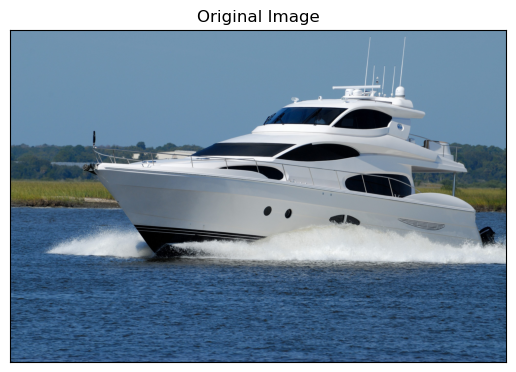

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], [])

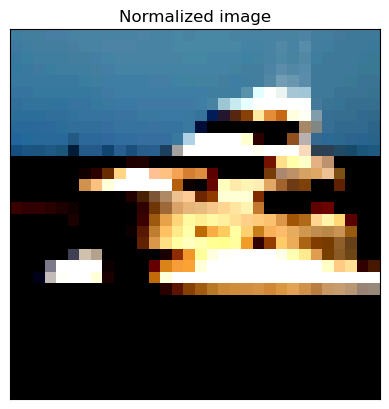

In [117]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
 
# load the image
img_path = 'imgs/boat1.jpg'
img = Image.open(img_path)
 
# convert image to numpy array
img_np = np.array(img)

plt.imshow(img_np)
plt.title("Original Image")
plt.xticks([])
plt.yticks([])
plt.show()

# Transformed and rezised image
transform = transforms.Compose([
    transforms.Resize((32, 32)),
	transforms.ToTensor()
])
img_transformed = transform(img)
img_transformed = np.array(img_transformed).transpose(1, 2, 0)

plt.imshow(img_transformed)
plt.title("Rezised image")
plt.xticks([])
plt.yticks([])
plt.show()


# Normalized image
transform_norm = transforms.Compose([
	transforms.Resize((32, 32)),
	transforms.ToTensor(),
	transforms.Normalize(mean, std)
])
img_normalized = transform_norm(img)
img_normalized = np.array(img_normalized).transpose(1, 2, 0)

plt.imshow(img_normalized)
plt.title("Normalized image")
plt.xticks([])
plt.yticks([])
